In [1]:
import torch

from model import *
from data import *
from vis import *
import gc

import itertools

In [2]:
config = Config().load("config.json")

In [3]:
def trainModel(config, modelClass, dataClass, objective, epochs, criterion: dict[str: nn.Module]):
    model = None
    try:
        dataset = dataClass(config)

        dataset.info(dataset[0])

        trainSize = len(dataset)
        # TODO: More stratified subsets using dataset.lengths and geographic information
        train = torch.utils.data.Subset(dataset, range(int(trainSize * config.dataSplit)))
        test = torch.utils.data.Subset(dataset, range(int(trainSize * config.dataSplit), trainSize))

        trainSampler = GraphSizeSampler(train, nodesPerBatch=config.nodesPerBatch, force=True)
        testSampler = GraphSizeSampler(test, nodesPerBatch=config.nodesPerBatch, force=True)

        train = DataLoader(train, batch_sampler=trainSampler, generator=torch.Generator(device))
        test = DataLoader(test, batch_sampler=testSampler, generator=torch.Generator(device))

        dataset.info(next(iter(train)))

        model = modelClass(config)
        print(f"Model has {sum([p.numel() for p in model.parameters()])} parameters")
        print(f"Dataset has {len(dataset)} samples")
        print(next(model.parameters()).is_cuda)

        precision, recall, mae = CMALPrecision(), CMALRecall(), CMALNormalizedMeanAbsolute()

        optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

        testIter = itertools.cycle(test)

        client = Client("127.0.0.1")

        totalMemory = []

        for epoch in range(epochs):
            progress = 0
            for inputs, targets in train:
                memoryTrack = [torch.cuda.memory_allocated()]

                model.train()
                optimizer.zero_grad()

                memoryTrack.append(torch.cuda.memory_allocated())

                history, future = targets.dischargeHistory, targets.dischargeFuture
                memoryTrack.append(torch.cuda.memory_allocated())
                thresholds, deviations = targets.thresholds, targets.deviation.unsqueeze(1)
                memoryTrack.append(torch.cuda.memory_allocated())
                hindcast, forecast = model(inputs)
                memoryTrack.append(torch.cuda.memory_allocated())
                loss = objective(forecast, future)
                memoryTrack.append(torch.cuda.memory_allocated())
                trainLoss = loss.detach().item()
                memoryTrack.append(torch.cuda.memory_allocated())

                # trainPrecision, trainRecall = precision(forecast, future, thresholds), recall(forecast, future, thresholds)
                trainMAE = mae(forecast, future, deviations).detach().item()
                memoryTrack.append(torch.cuda.memory_allocated())

                loss.backward()
                memoryTrack.append(torch.cuda.memory_allocated())
                optimizer.step()
                memoryTrack.append(torch.cuda.memory_allocated())

                # For the love of god
                del loss, history, future, thresholds, deviations, hindcast, forecast, inputs, targets
                memoryTrack.append(torch.cuda.memory_allocated())

                print("Memory added: ", memoryTrack[-1] - memoryTrack[0])
                print(memoryTrack)
                totalMemory.append(memoryTrack)
                np.save("memory.npy", np.array(totalMemory))

                # torch.cuda.empty_cache()

                with torch.no_grad():
                    model.eval()
                    inputs, targets = next(testIter)

                    history, future = targets.dischargeHistory, targets.dischargeFuture
                    thresholds, deviations = targets.thresholds, targets.deviation.unsqueeze(1)
                    hindcast, forecast = model(inputs)
                    loss = objective(forecast, future)
                    testLoss = loss.detach().item()

                    # testPrecision, testRecall = precision(forecast, future, thresholds), recall(forecast, future, thresholds)
                    testMAE = mae(forecast, future, deviations).detach().item()

                    del loss, history, future, thresholds, deviations, hindcast, forecast, inputs, targets

                torch.cuda.empty_cache()

                client.send("Train Loss", trainLoss)
                client.send("Test Loss", testLoss)
                client.send("Train NMAE", trainMAE)
                client.send("Test NMAE", testMAE)

                progress += 1
                # print(f"\r{progress}/{len(train)} | {(progress / len(train)) * 100:.3f}% |  Train Loss: {trainLoss} | Train Precision: {precision} | Train Recall: {recall}")
                print(f"\r{progress}/{len(train)} | {(progress / len(train)) * 100:.3f}% |  Train Loss: {trainLoss} | Test Loss: {testLoss}", end="")

            print()

        return model

    except KeyboardInterrupt:
        if model is not None:
            torch.save(model.state_dict(), "checkpoint.pt")
        return model

Loading GeoPandas...
GeoPandas Loaded
2544/2544 GRDC files loaded
9640/9640 ERA5 files loaded
Total empty basins: 37
57622/57646 Basin Structures Appended to Graph
Upstream Basins Compiled | 1.0 | 17.43485477178423
Upstream Structures Compiled
Structure Tensors Complete
Index Mapping Complete
Static Input Scaling Complete

        Total Samples: 29254761
        Era5 History: torch.Size([1, 120, 7]) torch.float32
        Era5 Future: torch.Size([1, 7, 7]) torch.float32
        Basin Continuous: torch.Size([1, 277]) torch.float32
        Basin Discrete: torch.Size([1, 10]) torch.int64
        Structure: torch.Size([2, 1]) torch.int64
        River Continuous: torch.Size([258]) torch.float32
        River Discrete: torch.Size([14]) torch.int64
        Discharge History: torch.Size([120]) torch.float32
        Discharge Future: torch.Size([7]) torch.float32
        Thresholds: torch.Size([4]) torch.float32
        Deviation: torch.Size([]) torch.float32
        


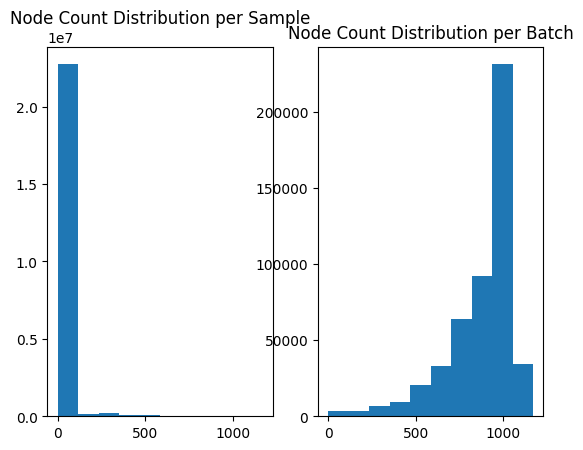

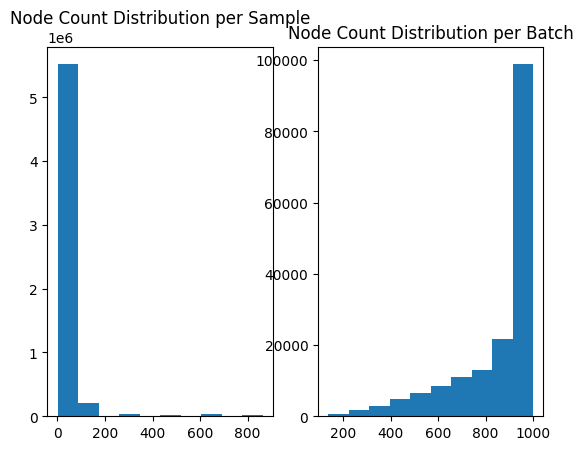

In [ ]:
metrics = {
    "Precision": CMALLoss()
}

model = trainModel(config, InundationStation, InundationData, CMALLoss(), epochs=10, criterion=metrics)